In [2]:
import sys
sys.path.append('../')
from SynRBL.rsmi_utils import *
import pandas as pd
import numpy as np
from joblib import Parallel, delayed
from SynRBL.rsmi_utils import load_database, filter_data
reactions_clean = load_database('../Data/reaction_clean.json.gz')
filtered_data_1 = filter_data(reactions_clean, unbalance_values=['Reactants', 'Products'], formula_key='Diff_formula', element_key='C', min_count=1, max_count=10000)
len(filtered_data_1)

13752

In [3]:
filtered_data_2 = filter_data(reactions_clean, unbalance_values=['Both'], formula_key='Diff_formula', element_key='C', min_count=0, max_count=10000)
len(filtered_data_2)

3088

In [4]:
filtered_data = filtered_data_1 + filtered_data_2
len(filtered_data)

16840

In [5]:
from rdkit import Chem
from rdkit.Chem import rdmolops
from rdkit.Chem import rdFMCS

class MCSMissingGraphAnalyzer:
    """A class for detecting missing graph in reactants and products using MCS and RDKit."""

    def __init__(self):
        """Initialize the MolecularOperations class."""
        pass
    
    @staticmethod
    def get_smiles(reaction_dict):
        """
        Extract reactant and product SMILES strings from a reaction dictionary.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing reactant SMILES and product SMILES strings.
        """
        return reaction_dict['reactants'], reaction_dict['products']

    @staticmethod
    def convert_smiles_to_molecule(smiles):
        """
        Convert a SMILES string to an RDKit molecule object.

        Parameters:
        - smiles: str
            The SMILES string representing a molecule.

        Returns:
        - rdkit.Chem.Mol
            The RDKit molecule object.
        """
        return Chem.MolFromSmiles(smiles)

    @staticmethod
    def mol_to_smiles(mol):
        """
        Convert an RDKit molecule object to a SMILES string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMILES string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmiles(mol) if mol else None

    @staticmethod
    def mol_to_smarts(mol):
        """
        Convert an RDKit molecule object to a SMARTS string.

        Parameters:
        - mol: rdkit.Chem.Mol
            The RDKit molecule object.

        Returns:
        - str or None
            The SMARTS string representation of the molecule, or None if the molecule is None.
        """
        return Chem.MolToSmarts(mol) if mol else None

    @staticmethod
    def find_maximum_common_substructure(mol1, mol2, ringMatchesRingOnly=True):
        """
        Find the maximum common substructure (MCS) between two molecules.

        Parameters:
        - mol1, mol2: rdkit.Chem.Mol
            The RDKit molecule objects to compare.

        Returns:
        - rdkit.Chem.Mol or None
            The RDKit molecule object representing the MCS, or None if MCS search was canceled.
        """
        mcs_result = rdFMCS.FindMCS([mol1, mol2], ringMatchesRingOnly=ringMatchesRingOnly)
        if mcs_result.canceled:
            return None
        mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
        return mcs_mol

    def IterativeMCSReactionPairs(reactant_mol_list, product_mol, params=None):
        """
        Find the MCS for each reactant fragment with the product, updating the product after each step.
        Sorts the reactants based on the size of their MCS with the product.

        Parameters:
        - reactant_mol_list: list of rdkit.Chem.Mol
            List of RDKit molecule objects for reactants.
        - product_mol: rdkit.Chem.Mol
            RDKit molecule object for the product.

        Returns:
        - list of rdkit.Chem.Mol
            List of RDKit molecule objects representing the MCS for each reactant-product pair.
        - list of rdkit.Chem.Mol
            Sorted list of reactant molecule objects.
        """
        # Calculate the MCS for each reactant with the product
        mcs_results = [(reactant, rdFMCS.FindMCS([reactant, product_mol], params)) for reactant in reactant_mol_list]

        # Filter out any canceled MCS results and sort by size of MCS
        mcs_results = [(reactant, mcs_result) for reactant, mcs_result in mcs_results if not mcs_result.canceled]
        sorted_reactants = sorted(mcs_results, key=lambda x: x[1].numAtoms, reverse=True)

        mcs_list = []
        current_product = product_mol

        # Process the sorted reactants
        for reactant, mcs_result in sorted_reactants:
            mcs_mol = Chem.MolFromSmarts(mcs_result.smartsString)
            mcs_list.append(mcs_mol)

            # Update the product by removing the MCS substructure
            current_product = Chem.DeleteSubstructs(Chem.RWMol(current_product), mcs_mol)
            current_product = Chem.RemoveHs(current_product)
            try:
                Chem.SanitizeMol(current_product)
            except:
                pass

        # Extract only the reactant molecules from sorted_reactants for return
        sorted_reactant_mols = [reactant for reactant, _ in sorted_reactants]

        return mcs_list, sorted_reactant_mols

    
    @staticmethod
    def add_hydrogens_to_radicals(mol):
        """
        Add hydrogen atoms to radical sites in a molecule.

        Parameters:
        - mol: rdkit.Chem.Mol
            RDKit molecule object.

        Returns:
        - rdkit.Chem.Mol
            The modified molecule with added hydrogens.
        """
        if mol:
            # Create a copy of the molecule
            mol_with_h = Chem.RWMol(mol)

            # Add explicit hydrogens (not necessary if they are already present in the input molecule)
            mol_with_h = rdmolops.AddHs(mol_with_h)

            # Find and process radical atoms
            for atom in mol_with_h.GetAtoms():
                num_radical_electrons = atom.GetNumRadicalElectrons()
                if num_radical_electrons > 0:
                    atom.SetNumExplicitHs(atom.GetNumExplicitHs() + num_radical_electrons)
                    atom.SetNumRadicalElectrons(0)
            curate_mol = Chem.RemoveHs(mol_with_h)
            # Return the molecule with added hydrogens
            return curate_mol

    @staticmethod
    def fit(reaction_dict, params=None):
        """
        Process a reaction dictionary to find MCS, missing parts in reactants and products.

        Parameters:
        - reaction_dict: dict
            A dictionary containing 'reactants' and 'products' as keys.

        Returns:
        - tuple
            A tuple containing lists of MCS, missing parts in reactants, missing parts in products,
            reactant molecules, and product molecules.
        """
        reactant_smiles, product_smiles = MCSMissingGraphAnalyzer.get_smiles(reaction_dict)
        reactant_mol_list = [MCSMissingGraphAnalyzer.convert_smiles_to_molecule(smiles) for smiles in reactant_smiles.split('.')]
        product_mol = MCSMissingGraphAnalyzer.convert_smiles_to_molecule(product_smiles)

        mcs_list, sorted_reactants = MCSMissingGraphAnalyzer.IterativeMCSReactionPairs(reactant_mol_list, product_mol,  params)

        return mcs_list , sorted_reactants, product_mol

In [6]:
from rdkit import Chem
def find_missing_parts_pairs(mol_list, mcs_list):
    """
    This function analyzes each molecule in a given list and identifies the parts that are not 
    present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
    atoms and nearest neighbors for each molecule.

    Parameters:
    - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
    - mcs_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing MCS, 
    corresponding to each molecule in mol_list.

    Returns:
    Tuple containing:
    - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
    of each molecule, or None if no missing parts are found.
    - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
    - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
    """
    missing_parts_list = []
    boundary_atoms_lists = []
    nearest_neighbor_lists = []

    for mol, mcs_mol in zip(mol_list, mcs_list):
        atoms_to_remove = set()
        boundary_atoms_list = []
        nearest_neighbor_list = []

        if mcs_mol:
            # Special case handling (e.g., single oxygen atom)
            if Chem.MolToSmiles(mcs_mol) == 'O':
                smarts_pattern = '[OH]'
                smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                substructure_match = mol.GetSubstructMatch(smarts_mol)
                rw_mol = Chem.RWMol(mol)
                rw_mol.RemoveAtom(substructure_match[0])
                missing_part = rw_mol.GetMol()
                boundary_atoms = [{'O': 0}]
                nearest_atoms = [{'O': 0}]
            else:
                # Finding substructure matches
                substructure_match = mol.GetSubstructMatch(mcs_mol)
                if substructure_match:
                    atoms_to_remove.update(substructure_match)

                # Creating the molecule of missing parts
                missing_part = Chem.RWMol(mol)
                for idx in sorted(atoms_to_remove, reverse=True):
                    missing_part.RemoveAtom(idx)

                # Mapping indices from original to missing part molecule
                index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                boundary_atoms = []
                nearest_atoms = []

                # Identifying boundary atoms and nearest neighbors
                for atom_idx in substructure_match:
                    if atom_idx < mol.GetNumAtoms():
                        atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                        neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                        # Loop through neighbors to find boundary atoms and nearest neighbors
                        for neighbor in neighbors:
                            if neighbor.GetIdx() not in substructure_match:
                                nearest_atoms.append({atom_symbol: atom_idx})
                                renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                if renumerate_idx != -1:
                                    boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

            if boundary_atoms:
                boundary_atoms_list.append(boundary_atoms)
            if nearest_atoms:
                nearest_neighbor_list.append(nearest_atoms)

        try:
            Chem.SanitizeMol(missing_part)
            if missing_part.GetNumAtoms() > 0:
                missing_parts_list.append(missing_part)
                boundary_atoms_lists.extend(boundary_atoms_list)
                nearest_neighbor_lists.extend(nearest_neighbor_list)
            else:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])
        except:
            #missing_parts_list.append(None)
            boundary_atoms_lists.extend([])
            nearest_neighbor_lists.extend([])

    return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists

In [34]:
from rdkit.Chem import AllChem, rdChemReactions
#from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

def display_reaction(reaction_dict, reaction_key='reactions', use_smiles=True):
    """
    Displays a chemical reaction using RDKit.

    Parameters:
    - reaction_dict: A dictionary containing reaction data.
    - reaction_key: Key to access reaction information in the dictionary.
    - use_smiles: Whether to use SMILES format for the reaction.
    """
    return rdChemReactions.ReactionFromSmarts(reaction_dict[reaction_key], useSmiles=use_smiles)



In [35]:
def single_impute(data_dict, params=None):
    """
    Performs imputation on a single reaction data entry and captures any issues encountered.

    Parameters:
    - data_dict: Dict containing reaction data.
    - params: Optional parameters for MCS analysis.

    Returns:
    - dict: A dictionary containing imputation results and any issues encountered.
    """
    from rdkit import Chem
    from SynRBL.SynMCS.mcs_missing_graph_analyzer import MCSMissingGraphAnalyzer
    from SynRBL.SynMCS.find_missing_graphs import find_missing_parts_pairs

    impute_dict = {'impute_product_smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}

    try:
        analyzer = MCSMissingGraphAnalyzer()
        mcs_list, sorted_reactants, product_mol = analyzer.fit(data_dict, params=params)
        impute_product_frags, boundary_atoms_products, nearest_neighbor_products = find_missing_parts_pairs(sorted_reactants, mcs_list)
        impute_product_smiles = [Chem.MolToSmiles(impute_product) for impute_product in impute_product_frags]

        impute_dict['impute_product_smiles'] = impute_product_smiles
        impute_dict['boundary_atoms_products'] = boundary_atoms_products
        impute_dict['nearest_neighbor_products'] = nearest_neighbor_products

    except Exception as e:
        display_reaction(data_dict)
        impute_dict['issue'] = data_dict

    return impute_dict


In [36]:
final = Parallel(n_jobs=8)(delayed(single_impute)(data_dict) for data_dict in filtered_data[100:300])

[15:14:24] non-ring atom 2 marked aromatic


In [25]:
final = pd.DataFrame(final)
df = final.applymap(lambda x: np.nan if x == [] else x)

# Display the DataFrame
display(df.head())

/var/folders/t0/4s7kmdv11y93hgspz_xf83jc0000gn/T/ipykernel_52575/3640427241.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = final.applymap(lambda x: np.nan if x == [] else x)


,impute_product_smiles,boundary_atoms_products,nearest_neighbor_products,issue
0,[O=COCc1ccccc1],[[{'C': 0}]],[[{'N': 9}]],NaN
1,"[CC1(C)OBOC1(C)C, Br]","[[{'B': 4}], [{'Br': 0}]]","[[{'C': 5}], [{'C': 13}]]",NaN
2,[CC(C)C],[[{'C': 1}]],[[{'O': 4}]],NaN
3,[COc1ccc(C)cc1],[[{'C': 0}]],[[{'N': 8}]],NaN
4,[C],[[{'C': 0}]],[[{'O': 1}]],NaN


In [29]:
df['impute_product_smiles'].isnull().sum()

0

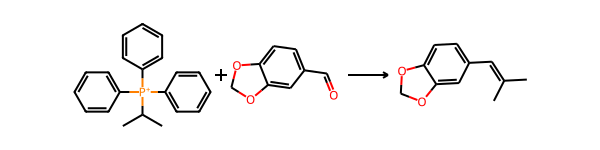

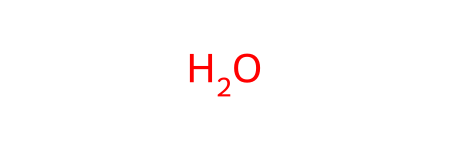

Boundary list for fragment 0 : [{'O': 0}]
Nearest neighbor list for fragment 0 : [{'C': 1}]


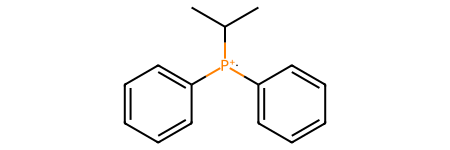

Boundary list for fragment 1 : [{'P': 3}]
Nearest neighbor list for fragment 1 : [{'C': 4}]


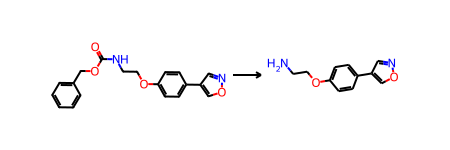

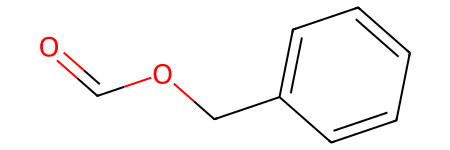

Boundary list for fragment 0 : [{'C': 1}]
Nearest neighbor list for fragment 0 : [{'N': 2}]


# Test

In [1]:
import sys
import pandas as pd
sys.path.append('../../')
from SynRBL.SynMCS import FindMissingGraphs

In [2]:
from SynRBL.rsmi_utils import load_database, save_database
from SynRBL.SynMCS.mcs_utils import smiles_to_mol_parallel
from SynRBL.SynMCS.find_missing_graphs import FindMissingGraphs
mcs_dict = load_database('../../Data/MCS/Intersection_MCS_3+_matching_ensemble.json.gz')

In [3]:
msc_df = pd.DataFrame(mcs_dict)

mcs_results = msc_df['mcs_results'].to_list()
sorted_reactants = msc_df['sorted_reactants'].to_list()

mcs_mol_list = smiles_to_mol_parallel(mcs_results)
sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

[22:04:24] Can't kekulize mol.  Unkekulized atoms: 5 6 18 19 20
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 22
[22:04:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 18 19 20 21 22 23 24 25 26
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 9 11 25 26 27
[22:04:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 10 11
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 6 21 22 23 24
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 8 9 10 11 12 13 16 17 18
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 2 3 4 5 23 24 25 26 27 28 32 33 34
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 5 6 7 8 12
[22:04:24] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 8 9 14 15
[22:04:24] Explicit valence for atom # 1 N, 4, is greater than permitted
[22:

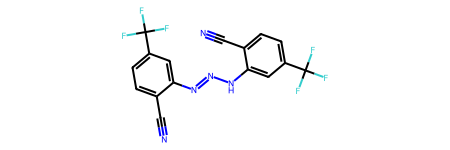

In [4]:
sorted_reactants_mol_list[24][0]

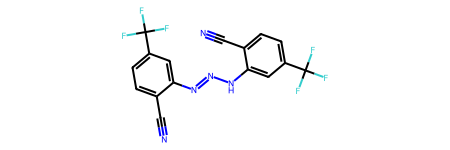

In [5]:
mcs_mol_list[24][0]

In [10]:
from rdkit import Chem
Chem.MolToSmiles(mcs_mol_list[24][1])

'CC=O'

In [11]:

Chem.MolToSmiles(sorted_reactants_mol_list[24][1])

'CC(=O)OC(C)=O'

In [ ]:
find_graph = FindMissingGraphs()
    missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=n_jobs, use_findMCS=use_findMCS)
    missing_final = pd.DataFrame(missing_results)


In [ ]:
mcs_dict = load_database(msc_dict_path)

    msc_df = pd.DataFrame(mcs_dict)

    mcs_results = msc_df['mcs_results'].to_list()
    sorted_reactants = msc_df['sorted_reactants'].to_list()

    mcs_mol_list = smiles_to_mol_parallel(mcs_results)
    sorted_reactants_mol_list = smiles_to_mol_parallel(sorted_reactants)

    find_graph = FindMissingGraphs()
    missing_results = find_graph.find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=n_jobs, use_findMCS=use_findMCS)
    missing_final = pd.DataFrame(missing_results)

    missing_final = missing_final.map(lambda x: np.nan if x == '' else x)
    non_pass_df = missing_final.iloc[missing_final.dropna(subset=['issue']).index,:].to_dict(orient='records')
    print('Bug:', len(non_pass_df))
    if save:
        save_database(missing_results, save_path)
    
    return missing_results

In [38]:
from rdkit import Chem
parent_mol = Chem.MolFromSmiles('CC(=O)OC(C)=O')
child_mol = Chem.MolFromSmiles('CC(=O)O')
mcs_mol = Chem.MolFromSmiles('CC=O')

def map_parent_to_child(parent_mol, child_mol, mcs_mol):
    # Get atom indices for MCS in the parent molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(mcs_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    child_atom_idx = 0

    for parent_atom_idx in range(parent_mol.GetNumAtoms()):
        if parent_atom_idx not in parent_mcs_indices:
            # Assuming the non-MCS atoms in the parent are in the same order as in the child
            atom_mapping[parent_atom_idx] = child_atom_idx
            child_atom_idx += 1

    return atom_mapping

# Example usage



atom_mapping = map_parent_to_child(parent_mol, child_mol, mcs_mol)



In [46]:
def map_parent_to_child(parent_mol, child_mol):
    # Get atom indices in the parent molecule that match the entire child molecule
    parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

    # Create a mapping of parent atom indices to child atom indices
    atom_mapping = {}
    for child_idx, parent_idx in enumerate(parent_mcs_indices):
        atom_mapping[parent_idx] = child_idx

    return atom_mapping

# Example usage
atom_mapping = map_parent_to_child(parent_mol, child_mol)


In [47]:
atom_mapping

{0: 0, 1: 1, 2: 2, 3: 3}

In [45]:
parent_mcs_indices

(0, 1, 2, 3)

In [43]:
parent_mcs_indices = parent_mol.GetSubstructMatch(mcs_mol)
parent_mcs_indices

(0, 1, 2)

In [39]:
atom_mapping

{3: 0, 4: 1, 5: 2, 6: 3}

In [34]:
parent_mcs_indices = parent_mol.GetSubstructMatch(mcs_mol)
child_mcs_indices = child_mol.GetSubstructMatch(mcs_mol)


In [36]:
parent_mcs_indices

(0, 1, 2)

In [37]:
child_mcs_indices

(0, 1, 2)

In [33]:
atom_mapping

{0: 0, 1: 1, 2: 2, None: 3}

In [28]:
atom_mapping[0]

0

In [1]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed

class FindMissingGraphs:
    """
    A class for finding missing parts, boundary atoms, and nearest neighbors in a list of reactant molecules.

    Usage:
    1. Create an instance of the class.
    2. Use the class methods to find missing parts, boundary atoms, and nearest neighbors for a list of molecules.

    Example:
    ```
    fm = FindMissingGraphs()
    missing_results = fm.find_single_graph(mcs_mol_list, sorted_reactants_mol_list)
    ```

    Note: This class requires the RDKit library to be installed.

    Attributes:
    None

    Methods:
    - find_missing_parts_pairs: Analyze a list of molecules and identify missing parts, boundary atoms, and nearest neighbors.
    - find_single_graph: Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules.
    - find_single_graph_parallel: Find missing parts, boundary atoms, and nearest neighbors in parallel for a list of reactant molecules.
    """

    def __init__(self):
        pass

    @staticmethod
    def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=False, params=None):
        """
        This function analyzes each molecule in a given list and identifies the parts that are not 
        present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
        atoms and nearest neighbors for each molecule.

        Parameters:
        - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
        corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
        - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
        - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

        Returns:
        Tuple containing:
        - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
        of each molecule, or None if no missing parts are found.
        - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
        - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
        """
        missing_parts_list = []
        boundary_atoms_lists = []
        nearest_neighbor_lists = []

        for mol, mcs_mol in zip(mol_list, mcs_list):
            atoms_to_remove = set()
            boundary_atoms_list = []
            nearest_neighbor_list = []

            if use_findMCS:
                # Calculate MCS using RDKit's rdFMCS
                mcs = rdFMCS.FindMCS([mol, mcs_mol], params)
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            
            try:
                if mcs_mol:
                    # Special case handling (e.g., single oxygen atom)
                    if Chem.MolToSmiles(mcs_mol) == 'O':
                        smarts_pattern = '[OH]'
                        smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                        substructure_match = mol.GetSubstructMatch(smarts_mol)
                        rw_mol = Chem.RWMol(mol)
                        rw_mol.RemoveAtom(substructure_match[0])
                        missing_part = rw_mol.GetMol()
                        boundary_atoms = [{'O': 0}]
                        nearest_atoms = [{'O': 0}]
                    else:
                        raise ValueError
            except:
                if mcs_mol:
                    # Finding substructure matches
                    substructure_match = mol.GetSubstructMatch(mcs_mol)
                    if substructure_match:
                        atoms_to_remove.update(substructure_match)

                    # Creating the molecule of missing parts
                    missing_part = Chem.RWMol(mol)
                    for idx in sorted(atoms_to_remove, reverse=True):
                        missing_part.RemoveAtom(idx)

                    # re-index
                    if missing_part is not None:
                    #AM = False
                    
                        missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                    #try:
                        atom_mapping = FindMissingGraphs.map_parent_to_child(mol, missing_part)
                        #AM=True
                    #except:
                    #    pass
                    # Mapping indices from original to missing part molecule
                    else:
                        index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                    boundary_atoms = []
                    nearest_atoms = []

                    # Identifying boundary atoms and nearest neighbors
                    for atom_idx in substructure_match:
                        if atom_idx < mol.GetNumAtoms():
                            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            # Loop through neighbors to find boundary atoms and nearest neighbors
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({atom_symbol: atom_idx})
                                
                                    #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                    #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    if missing_part:
                                        renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    else:
                                        renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                    if renumerate_idx != -1:
                                        boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

                if boundary_atoms:
                    boundary_atoms_list.append(boundary_atoms)
                if nearest_atoms:
                    nearest_neighbor_list.append(nearest_atoms)

            try:
                Chem.SanitizeMol(missing_part)
                if missing_part.GetNumAtoms() > 0:
                    missing_parts_list.append(missing_part)
                    boundary_atoms_lists.extend(boundary_atoms_list)
                    nearest_neighbor_lists.extend(nearest_neighbor_list)
                else:
                    #missing_parts_list.append(None)
                    boundary_atoms_lists.extend([])
                    nearest_neighbor_lists.extend([])
            except:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])

        return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists
    

    @staticmethod
    def find_single_graph(mcs_mol_list, sorted_reactants_mol_list, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.

        Returns:
        - Dictionary containing:
        - 'smiles' (list of list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (list): Any issues encountered during processing.
        """
        missing_results = {'smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}
        for i in zip(sorted_reactants_mol_list, mcs_mol_list):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(i[0], i[1], use_findMCS=use_findMCS)
                missing_results['smiles'].append([Chem.MolToSmiles(mol) for mol in mols])
                missing_results['boundary_atoms_products'].append(boundary_atoms_products)
                missing_results['nearest_neighbor_products'].append(nearest_neighbor_products)
                missing_results['issue'].append([])
            except Exception as e:
                missing_results['smiles'].append([])
                missing_results['boundary_atoms_products'].append([])
                missing_results['nearest_neighbor_products'].append([])
                missing_results['issue'].append(str(e))
        return missing_results

    @staticmethod
    def find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=-1, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules in parallel.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - n_jobs (int): The number of parallel jobs to run. Default is -1, which uses all available CPU cores.

        Returns:
        - List of dictionaries, where each dictionary contains:
        - 'smiles' (list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (str): Any issues encountered during processing.
        """
        def process_single_pair(reactant_mol, mcs_mol, use_findMCS=True):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(reactant_mol, mcs_mol, use_findMCS=use_findMCS)
                return {
                    'smiles': [Chem.MolToSmiles(mol) for mol in mols],
                    'boundary_atoms_products': boundary_atoms_products,
                    'nearest_neighbor_products': nearest_neighbor_products,
                    'issue': ''
                }
            except Exception as e:
                return {
                    'smiles': [],
                    'boundary_atoms_products': [],
                    'nearest_neighbor_products': [],
                    'issue': str(e)
                }

        results = Parallel(n_jobs=n_jobs)(delayed(process_single_pair)(reactant_mol, mcs_mol, use_findMCS=use_findMCS) for reactant_mol, mcs_mol in zip(sorted_reactants_mol_list, mcs_mol_list))
        return results
    
    @staticmethod
    def map_parent_to_child(parent_mol, child_mol):
        # Get atom indices in the parent molecule that match the entire child molecule
        parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

        # Create a mapping of parent atom indices to child atom indices
        atom_mapping = {}
        for child_idx, parent_idx in enumerate(parent_mcs_indices):
            atom_mapping[parent_idx] = child_idx

        return atom_mapping
    
    @staticmethod
    def is_mapping_correct(mol, symbol_to_index):
        # Convert the molecule to a dictionary of atom indices to symbols
        molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
        
        # Check if the mappings are consistent
        for symbol, index in symbol_to_index.items():
            if index not in molecule_dict:
                return False
            if molecule_dict[index] != symbol:
                return False
        
        return True

In [6]:
from rdkit import Chem
from rdkit.Chem import rdFMCS
from joblib import Parallel, delayed

class FindMissingGraphs:
    """
    A class for finding missing parts, boundary atoms, and nearest neighbors in a list of reactant molecules.

    Usage:
    1. Create an instance of the class.
    2. Use the class methods to find missing parts, boundary atoms, and nearest neighbors for a list of molecules.

    Example:
    ```
    fm = FindMissingGraphs()
    missing_results = fm.find_single_graph(mcs_mol_list, sorted_reactants_mol_list)
    ```

    Note: This class requires the RDKit library to be installed.

    Attributes:
    None

    Methods:
    - find_missing_parts_pairs: Analyze a list of molecules and identify missing parts, boundary atoms, and nearest neighbors.
    - find_single_graph: Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules.
    - find_single_graph_parallel: Find missing parts, boundary atoms, and nearest neighbors in parallel for a list of reactant molecules.
    """

    def __init__(self):
        pass

    @staticmethod
    def find_missing_parts_pairs(mol_list, mcs_list=None, use_findMCS=False):
        """
        This function analyzes each molecule in a given list and identifies the parts that are not 
        present in the corresponding Maximum Common Substructure (MCS). It also finds the boundary 
        atoms and nearest neighbors for each molecule.

        Parameters:
        - mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - mcs_list (list of rdkit.Chem.Mol or None): List of RDKit molecule objects representing MCS, 
        corresponding to each molecule in mol_list. If None, MCS will be calculated using RDKit's rdFMCS.
        - use_findMCS (bool): Whether to use RDKit's rdFMCS to find MCS and remove it from mol_list.
        - params (rdkit.Chem.rdFMCS.MCSParameters): Parameters for RDKit's rdFMCS.

        Returns:
        Tuple containing:
        - list of rdkit.Chem.Mol or None: RDKit molecule objects representing the missing parts 
        of each molecule, or None if no missing parts are found.
        - list of lists: Each sublist contains the boundary atoms of the corresponding molecule.
        - list of lists: Each sublist contains the nearest neighbors of the corresponding molecule.
        """
        missing_parts_list = []
        boundary_atoms_lists = []
        nearest_neighbor_lists = []

        for mol, mcs_mol in zip(mol_list, mcs_list):
            atoms_to_remove = set()
            boundary_atoms_list = []
            nearest_neighbor_list = []

            if use_findMCS:
                # Calculate MCS using RDKit's rdFMCS
                params = rdFMCS.MCSParameters()
                #params.AtomTyper = rdFMCS.AtomCompare.CompareElements
                #params.BondTyper = rdFMCS.BondCompare.CompareOrder
                params.Timeout = 60
                params.BondCompareParameters.RingMatchesRingOnly = False
                params.BondCompareParameters.CompleteRingsOnly = False

                mcs = rdFMCS.FindMCS([mol, mcs_mol])
                mcs_mol = Chem.MolFromSmarts(mcs.smartsString)
            
            try:
                if mcs_mol:
                    # Special case handling (e.g., single oxygen atom)
                    if Chem.MolToSmiles(mcs_mol) == 'O':
                        smarts_pattern = '[OH]'
                        smarts_mol = Chem.MolFromSmarts(smarts_pattern)
                        substructure_match = mol.GetSubstructMatch(smarts_mol)
                        rw_mol = Chem.RWMol(mol)
                        rw_mol.RemoveAtom(substructure_match[0])
                        missing_part = rw_mol.GetMol()
                        boundary_atoms = [{'O': 0}]
                        nearest_atoms = [{'O': 0}]
                    else:
                        raise ValueError
            except:
                if mcs_mol:
                    # Finding substructure matches
                    substructure_match = mol.GetSubstructMatch(mcs_mol)
                    if substructure_match:
                        atoms_to_remove.update(substructure_match)

                    # Creating the molecule of missing parts
                    missing_part = Chem.RWMol(mol)
                    for idx in sorted(atoms_to_remove, reverse=True):
                        missing_part.RemoveAtom(idx)

                    # re-index
                    if missing_part is not None:
                    #AM = False
                    
                        missing_part = Chem.MolFromSmiles(Chem.MolToSmiles(missing_part))
                    #try:
                        atom_mapping = FindMissingGraphs.map_parent_to_child(mol, missing_part)
                        #AM=True
                    #except:
                    #    pass
                    # Mapping indices from original to missing part molecule
                    else:
                        index_mapping = {idx: i for i, idx in enumerate(sorted(set(range(mol.GetNumAtoms())) - atoms_to_remove))}

                    boundary_atoms = []
                    nearest_atoms = []

                    # Identifying boundary atoms and nearest neighbors
                    for atom_idx in substructure_match:
                        if atom_idx < mol.GetNumAtoms():
                            atom_symbol = mol.GetAtomWithIdx(atom_idx).GetSymbol()
                            neighbors = mol.GetAtomWithIdx(atom_idx).GetNeighbors()
                            # Loop through neighbors to find boundary atoms and nearest neighbors
                            for neighbor in neighbors:
                                if neighbor.GetIdx() not in substructure_match:
                                    nearest_atoms.append({atom_symbol: atom_idx})
                                
                                    #boundary_atoms.append({neighbor.GetSymbol(): atom_mapping[neighbor.GetIdx()]})
                                    #renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    if missing_part:
                                        renumerate_idx = atom_mapping.get(neighbor.GetIdx(), -1)
                                    else:
                                        renumerate_idx = index_mapping.get(neighbor.GetIdx(), -1)
                                    if renumerate_idx != -1:
                                        boundary_atoms.append({neighbor.GetSymbol(): renumerate_idx})

                if boundary_atoms:
                    boundary_atoms_list.append(boundary_atoms)
                if nearest_atoms:
                    nearest_neighbor_list.append(nearest_atoms)

            try:
                Chem.SanitizeMol(missing_part)
                if missing_part.GetNumAtoms() > 0:
                    missing_parts_list.append(missing_part)
                    boundary_atoms_lists.extend(boundary_atoms_list)
                    nearest_neighbor_lists.extend(nearest_neighbor_list)
                else:
                    #missing_parts_list.append(None)
                    boundary_atoms_lists.extend([])
                    nearest_neighbor_lists.extend([])
            except:
                #missing_parts_list.append(None)
                boundary_atoms_lists.extend([])
                nearest_neighbor_lists.extend([])

        return missing_parts_list, boundary_atoms_lists, nearest_neighbor_lists
    

    @staticmethod
    def find_single_graph(mcs_mol_list, sorted_reactants_mol_list, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.

        Returns:
        - Dictionary containing:
        - 'smiles' (list of list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (list): Any issues encountered during processing.
        """
        missing_results = {'smiles': [], 'boundary_atoms_products': [], 'nearest_neighbor_products': [], 'issue': []}
        for i in zip(sorted_reactants_mol_list, mcs_mol_list):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(i[0], i[1], use_findMCS=use_findMCS)
                missing_results['smiles'].append([Chem.MolToSmiles(mol) for mol in mols])
                missing_results['boundary_atoms_products'].append(boundary_atoms_products)
                missing_results['nearest_neighbor_products'].append(nearest_neighbor_products)
                missing_results['issue'].append([])
            except Exception as e:
                missing_results['smiles'].append([])
                missing_results['boundary_atoms_products'].append([])
                missing_results['nearest_neighbor_products'].append([])
                missing_results['issue'].append(str(e))
        return missing_results

    @staticmethod
    def find_single_graph_parallel(mcs_mol_list, sorted_reactants_mol_list, n_jobs=-1, use_findMCS=True):
        """
        Find missing parts, boundary atoms, and nearest neighbors for a list of reactant molecules
        using a corresponding list of MCS (Maximum Common Substructure) molecules in parallel.

        Parameters:
        - mcs_mol_list (list of rdkit.Chem.Mol): List of RDKit molecule objects representing the MCS,
        corresponding to each molecule in sorted_reactants_mol_list.
        - sorted_reactants_mol_list (list of rdkit.Chem.Mol): The list of RDKit molecule objects to analyze.
        - n_jobs (int): The number of parallel jobs to run. Default is -1, which uses all available CPU cores.

        Returns:
        - List of dictionaries, where each dictionary contains:
        - 'smiles' (list of str): SMILES representations of the missing parts for each molecule.
        - 'boundary_atoms_products' (list of dict): Lists of boundary atoms for each molecule.
        - 'nearest_neighbor_products' (list of dict): Lists of nearest neighbors for each molecule.
        - 'issue' (str): Any issues encountered during processing.
        """
        def process_single_pair(reactant_mol, mcs_mol, use_findMCS=True):
            try:
                mols, boundary_atoms_products, nearest_neighbor_products = FindMissingGraphs.find_missing_parts_pairs(reactant_mol, mcs_mol, use_findMCS=use_findMCS)
                return {
                    'smiles': [Chem.MolToSmiles(mol) for mol in mols],
                    'boundary_atoms_products': boundary_atoms_products,
                    'nearest_neighbor_products': nearest_neighbor_products,
                    'issue': ''
                }
            except Exception as e:
                return {
                    'smiles': [],
                    'boundary_atoms_products': [],
                    'nearest_neighbor_products': [],
                    'issue': str(e)
                }

        results = Parallel(n_jobs=n_jobs)(delayed(process_single_pair)(reactant_mol, mcs_mol, use_findMCS=use_findMCS) for reactant_mol, mcs_mol in zip(sorted_reactants_mol_list, mcs_mol_list))
        return results
    
    @staticmethod
    def map_parent_to_child(parent_mol, child_mol):
        # Get atom indices in the parent molecule that match the entire child molecule
        parent_mcs_indices = parent_mol.GetSubstructMatch(child_mol)

        # Create a mapping of parent atom indices to child atom indices
        atom_mapping = {}
        for child_idx, parent_idx in enumerate(parent_mcs_indices):
            atom_mapping[parent_idx] = child_idx

        return atom_mapping
    
    @staticmethod
    def is_mapping_correct(mol, symbol_to_index):
        # Convert the molecule to a dictionary of atom indices to symbols
        molecule_dict = {atom.GetIdx(): atom.GetSymbol() for atom in mol.GetAtoms()}
        
        # Check if the mappings are consistent
        for symbol, index in symbol_to_index.items():
            if index not in molecule_dict:
                return False
            if molecule_dict[index] != symbol:
                return False
        
        return True

In [7]:
find = FindMissingGraphs()

In [8]:
find.find_missing_parts_pairs(mol_list=sorted_reactants_mol_list[24], mcs_list=mcs_mol_list[24], use_findMCS=True)

NameError: name 'sorted_reactants_mol_list' is not defined

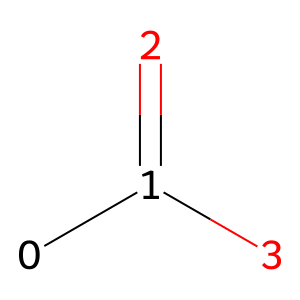

In [63]:
draw_molecule_with_atom_numbers(child_mol)

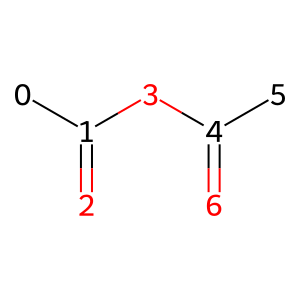

In [17]:
from rdkit import Chem
from rdkit.Chem import Draw

def draw_molecule_with_atom_numbers(mol):
    """
    Draw a molecule with atom numbers annotated.
    
    :param mol: RDKit Molecule object.
    :return: An image of the molecule with atom numbers.
    """
    # Create a copy of the molecule
    mol_with_atom_numbers = Chem.Mol(mol)
    
    # Add atom numbers
    for atom in mol_with_atom_numbers.GetAtoms():
        atom.SetProp('atomLabel', str(atom.GetIdx()))

    # Draw the molecule
    return Draw.MolToImage(mol_with_atom_numbers, size=(300, 300))

# Example usage
parent_smiles = 'CC(=O)OC(C)=O'
parent_mol = Chem.MolFromSmiles(parent_smiles)
image = draw_molecule_with_atom_numbers(parent_mol)
image


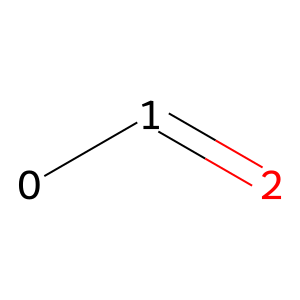

In [42]:
draw_molecule_with_atom_numbers(mcs_mol)

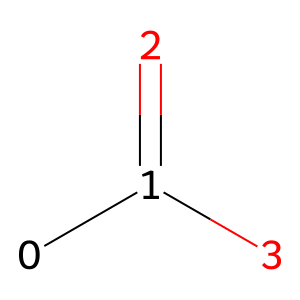

In [18]:
draw_molecule_with_atom_numbers(child_mol)

In [31]:
for neighbor in neighbors:
    if neighbor.GetIdx() not in substructure_match:
        nearest_atoms.append({atom_symbol: atom_idx})

{0: 0, 1: 1, 2: 2}

import st